In [28]:
#Imports and gym creation
import gym
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F

from gym import wrappers


In [76]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
random_seed = random.randint(0, 10000)

envCartPole = gym.make('CartPole-v1')
envCartPole.seed(random_seed)
envCartPole.action_space.seed(random_seed)

print('Random Seed:', random_seed)

Random Seed: 6311


In [84]:
EPISODES = 100
TRAIN_END = 0

In [85]:
def discount_rate(): #Gamma
    return 0.95

def learning_rate(): #Alpha
    return 0.001

def batch_size():
    return 64

In [86]:
class Q_Model(nn.Module):
    def __init__(self, nS, nA):
        super(Q_Model, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(nS, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, nA)
        )
    
    def forward(self, x):
        pred = self.model(x)
        return pred
        
class DoubleDeepQNetwork():
    def __init__(self, states, actions, alpha, gamma, epsilon,epsilon_min, epsilon_decay, device='cuda:0'):
        self.nS = states
        self.nA = actions
        self.memory = deque([], maxlen=2500)
        self.alpha = alpha
        self.gamma = gamma
        #Explore/Exploit
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.device = device
        self.model = Q_Model(self.nS, self.nA).to(self.device)
        self.model_target = Q_Model(self.nS, self.nA).to(self.device) #Second (target) neural network
        self.loss_fn = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = alpha)
        self.update_target_from_model() #Update weights
        self.loss = []
        self.q_value_estimate_each_period = []

    def update_target_from_model(self):
        #Update the target model from the base model
        self.model_target.load_state_dict(self.model.state_dict())

    def action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.nA) #Explore
        action_vals = self.model(torch.Tensor(state).to(self.device)).detach().cpu().numpy() #Exploit: Use the NN to predict the correct action from this state
        return np.argmax(action_vals[0])

    def test_action(self, state): #Exploit
        action_vals = self.model(torch.Tensor(state).to(self.device)).detach().cpu().numpy()
        return np.argmax(action_vals[0])

    def store(self, state, action, reward, nstate, done):
        #Store the experience in memory
        self.memory.append( (state, action, reward, nstate, done) )

    def experience_replay(self, batch_size):
        #Execute the experience replay
        minibatch = random.sample( self.memory, batch_size ) #Randomly sample from memory

        #Convert to numpy for speed by vectorization
        x = []
        y = []
        np_array = np.array(minibatch)
        st = np.zeros((0,self.nS)) #States
        nst = np.zeros( (0,self.nS) )#Next States
        for i in range(len(np_array)): #Creating the state and next state np arrays
            st = np.append( st, np_array[i,0], axis=0)
            nst = np.append( nst, np_array[i,3], axis=0)
        st_predict = self.model(torch.Tensor(st).to(self.device)).detach().cpu().numpy() #Here is the speedup! I can predict on the ENTIRE batch
        nst_predict = self.model(torch.Tensor(nst).to(self.device)).detach().cpu().numpy()
        nst_predict_target = self.model_target(torch.Tensor(nst).to(self.device)).detach().cpu().numpy() #Predict from the TARGET
        index = 0
        for state, action, reward, nstate, done in minibatch:
            x.append(state)
            #Predict from state
            nst_action_predict_target = nst_predict_target[index]
            nst_action_predict_model = nst_predict[index]
            if done == True: #Terminal: Just assign reward much like {* (not done) - QB[state][action]}
                target = reward
            else:   #Non terminal
                target = reward + self.gamma * nst_action_predict_target[np.argmax(nst_action_predict_model)] #Using Q to get T is Double DQN
            target_f = st_predict[index]
            target_f[action] = target
            y.append(target_f)
            index += 1
        #Reshape for Keras Fit
        x_reshape = np.array(x).reshape(batch_size,self.nS)
        y_reshape = torch.Tensor(np.array(y)).to(self.device)
        epoch_count = 1
        
        pred = self.model(torch.Tensor(x_reshape).to(self.device))
        loss = self.loss_fn(pred, y_reshape)
        self.optimizer.zero_grad()
        loss.backward()
        self.loss.append(loss.item())
        self.optimizer.step()
        
        #Decay Epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
    def estimate_q_value_from_replay_buffer(self, estimation_size):
        #Execute the experience replay
        minibatch = random.sample(self.memory, estimation_size ) #Randomly sample from memory

        #Convert to numpy for speed by vectorization
        x = []
        y = []
        np_array = np.array(minibatch)
        st = np.zeros((0,self.nS)) #States
        for i in range(len(np_array)): #Creating the state and next state np arrays
            st = np.append( st, np_array[i,0], axis=0)
        st_action_vals = self.model(torch.Tensor(st).to(self.device)).detach().cpu().numpy() # action_vals
        st_action_max_vals = np.max(st_action_vals, axis=1)
        
        self.q_value_estimate_each_period.append(np.mean(st_action_max_vals))

In [87]:
#Create the agents
nS = envCartPole.observation_space.shape[0] #This is only 4
nA = envCartPole.action_space.n #Actions
dqn = DoubleDeepQNetwork(nS, nA, learning_rate(), discount_rate(), 1, 0.001, 0.995, 'cuda:1')

batch_size = batch_size()

In [88]:
#Training

estimation_size = batch_size

rewards = [] #Store rewards for graphing
epsilons = [] # Store the Explore/Exploit
TEST_Episodes = 0
for e in tqdm(range(EPISODES)): #*****#
    state = envCartPole.reset()
    state = np.reshape(state, [1, nS]) # Resize to store in memory to pass to .predict
    tot_rewards = 0
    for time in range(210): #200 is when you "solve" the game. This can continue forever as far as I know
        
        #################################
        ##### Do Q value estimation #####
        
        if len(dqn.memory) > estimation_size:
            dqn.estimate_q_value_from_replay_buffer(estimation_size)
        
        #################################
        #################################
        
        action = dqn.action(state)
        nstate, reward, done, _= envCartPole.step(action)
        nstate = np.reshape(nstate, [1, nS])
        tot_rewards += reward
        dqn.store(state, action, reward, nstate, done) # Resize to store in memory to pass to .predict
        state = nstate
            
        #Experience Replay
        if len(dqn.memory) > batch_size:
            dqn.experience_replay(batch_size)
                
        #done: CartPole fell. 
        #time == 209: CartPole stayed upright
        if done or time == 209:
            rewards.append(tot_rewards)
            epsilons.append(dqn.epsilon)
            break # stop the episode
            
    #Update the weights after each episode (You can configure this for x steps as well
    dqn.update_target_from_model()
    
#     If our current NN passes we are done
#     I am going to use the last 10 runs
#     if len(rewards) > 10 and np.average(rewards[-10:]) > 195:
#         #Set the rest of the EPISODES for testing
#         TEST_Episodes = EPISODES - e
#         TRAIN_END = e
#         break

  0%|                                                                                                                         | 0/100 [00:00<?, ?it/s]/home/djinb1127/anaconda3/envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/djinb1127/anaconda3/envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:51<00:00,  

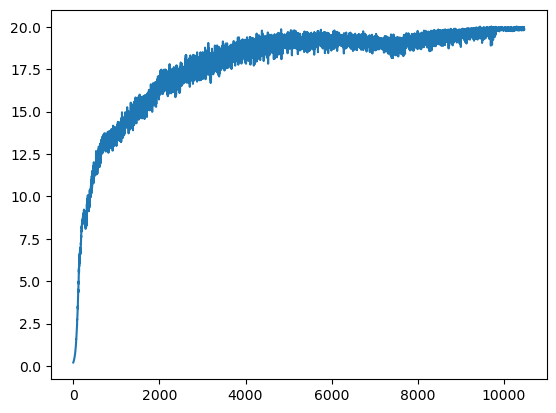

In [89]:
plt.plot(dqn.q_value_estimate_each_period)
plt.savefig('Q_value_estimates_per_step.png', dpi=300)

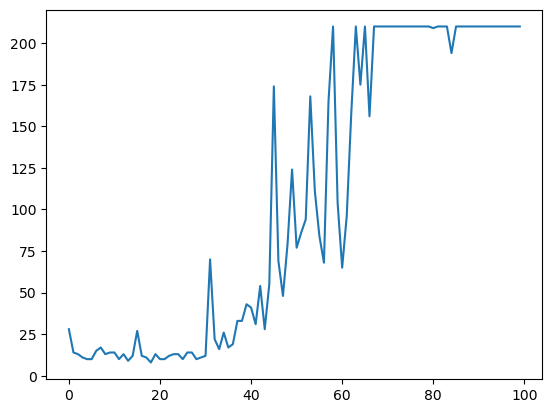

In [90]:
plt.plot(rewards)
plt.savefig('Reward_per_episode.png', dpi=300)

In [91]:
TEST_Episodes = 5
#Testing
print('Training complete. Testing started...')
#TEST Time
#   In this section we ALWAYS use exploit don't train any more
for e_test in range(TEST_Episodes):
    state = envCartPole.reset()
    state = np.reshape(state, [1, nS])
    tot_rewards = 0
    for t_test in range(210):
        action = dqn.test_action(state)
        nstate, reward, done, _ = envCartPole.step(action)
        nstate = np.reshape(nstate, [1, nS])
        tot_rewards += reward
        #DON'T STORE ANYTHING DURING TESTING
        state = nstate
        #done: CartPole fell. 
        #t_test == 209: CartPole stayed upright
        if done or t_test == 209: 
            rewards.append(tot_rewards)
            epsilons.append(0) #We are doing full exploit
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e_test, TEST_Episodes, tot_rewards, 0))
            break;

Training complete. Testing started...
episode: 0/5, score: 210.0, e: 0
episode: 1/5, score: 210.0, e: 0
episode: 2/5, score: 210.0, e: 0
episode: 3/5, score: 210.0, e: 0
episode: 4/5, score: 210.0, e: 0


In [13]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
df = pd.DataFrame()

for i in range(6):
    a = np.load('exp_{}_q_value_estimate_each_period.npy'.format(i+1))
    df[i] = a[:3942].tolist()

In [3]:
median = df.median(axis=1).tolist()
minimum = df.min(axis=1).tolist()
maximum = df.max(axis=1).tolist()

In [4]:
l = [minimum[i]*0.9 + maximum[i]*0.1 for i in range(len(minimum))]
h = [minimum[i]*0.1 + maximum[i]*0.9 for i in range(len(maximum))]

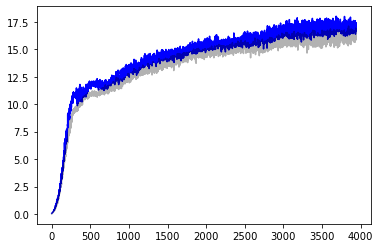

In [14]:
plt.plot(h, color='blue')
plt.plot(median, label='median', color='black', alpha=0.3)

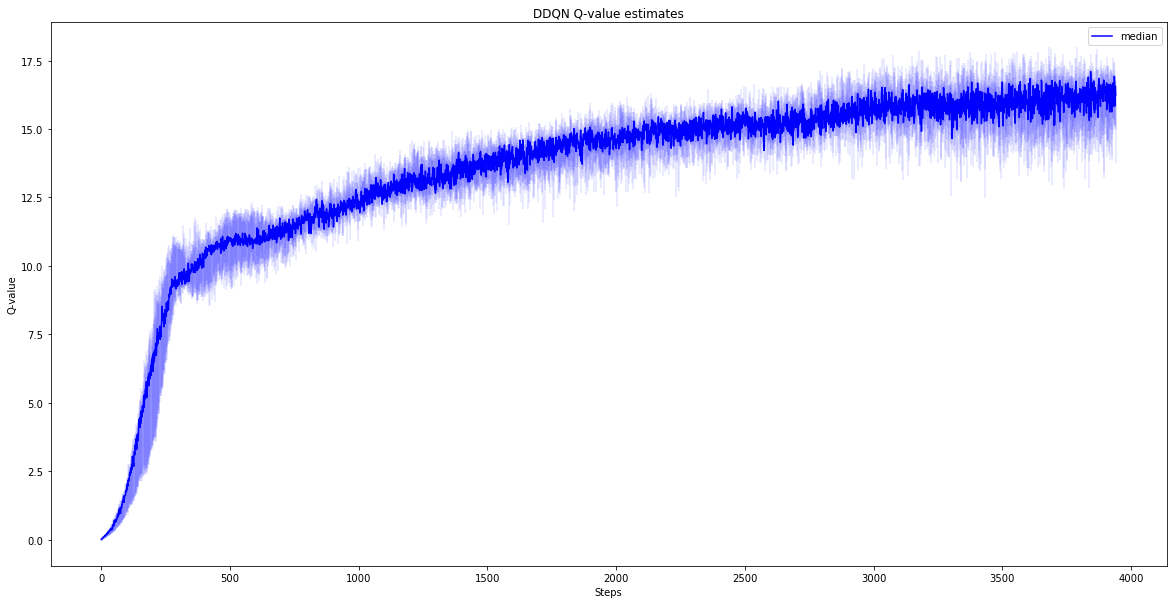

In [17]:
fig, ax = plt.subplots(figsize=(20, 10))

for i in range(len(l)):
    ax.vlines(x=i, ymin=l[i], ymax=h[i], color="blue", alpha=0.1)

plt.plot(median, label='median', color='blue')

plt.legend()
plt.title('DDQN Q-value estimates')
plt.ylabel('Q-value')
plt.xlabel('Steps')

plt.savefig('./DDQN_Q_value_estimates.png')